In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plta
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv (r'C:\אריאל\שנה א\סמסטר א\מבוא למדעי הנתונים\עבודת הגמר\Data_Science_intro_project\Regression\data_converted_to_english.csv', index_col = False)

In [3]:
df.replace('(^\s+|\s+$)', '', regex=True, inplace=True)

In [4]:
df.head()

,Product_Name,1_kg,Vitamin_B1,Vitamin_B6,Dietary_fiber,Folic_acid,energy,Proteins,Carbohydrates,Fats,...,chromium,Molybdenum,1_meter,100_meters,Unsaturated,Acidic_acid,Linoleic_acid,DHA,EPA,Chlorophyll
0,clementine,5.9,0.09,0.08,1.7,24.0,47.0,9.0,12.0,0.2,...,0,0,0,0,0,0,0,0,0,0
1,Gilded_apple,10.9,0.00,0.00,2.4,0.0,52.0,0.3,13.8,0.2,...,0,0,0,0,0,0,0,0,0,0
2,lemon,6.9,0.00,0.08,2.8,0.0,29.0,1.1,9.3,0.3,...,0,0,0,0,0,0,0,0,0,0
3,Orange_in_the_juice_network,4.9,0.09,0.06,2.5,39.0,49.0,1.0,11.9,0.3,...,0,0,0,0,0,0,0,0,0,0
4,Avocado,9.9,0.07,0.30,6.7,81.0,160.0,2.0,8.5,14.7,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9586 entries, 0 to 9585
Columns: 105 entries, Product_Name to Chlorophyll
dtypes: float64(27), int64(74), object(4)
memory usage: 7.7+ MB


In [6]:
df= df.set_index('Product_Name')

In [7]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state=42)

In [8]:
dfprod = train_set.copy()

In [9]:
for col in df.columns:  
    dfprod[col] = pd.to_numeric(dfprod[col], errors='coerce')
dfprod = dfprod.fillna(0)
dfprod = dfprod.loc[:, (df != 0).any(axis=0)]

In [10]:
dfprod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7668 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 98 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   1_kg                                 7668 non-null   float64
 1   Vitamin_B1                           7668 non-null   float64
 2   Vitamin_B6                           7668 non-null   float64
 3   Dietary_fiber                        7668 non-null   float64
 4   Folic_acid                           7668 non-null   float64
 5   energy                               7668 non-null   float64
 6   Proteins                             7668 non-null   float64
 7   Carbohydrates                        7668 non-null   float64
 8   Fats                                 7668 non-null   float64
 9   sodium                               7668 non-null   float64
 10  Vitamin_B3                           7668

### After a brief look at the cloumns we have, we pointed out a couple of things nedded to be done:
##### get rid of the unwanted units we have:
we want all the get rif of all the products that are not measured by 100_g or 1_kg (and delete the columns of these units).
afterwards, we need to unite the 100_g and 1_kg units (by deviding 1_kg by 10 we'll get the price for 100_g)
#### we'll check which columns left, and with them:
##### unite the columns:
- DHA_fatty_acid and DHA 
- Vitamin_A and Vitamin_A_is_worth_retinol 
- Dietary_fiber and Dietary_fiber.1 
- Potassium and K_Potassium (two different names to the same thing)
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E. (When referring generally to vitamin E, it is therefore related to the alpha-tocopherol form https://www.wikirefua.org.il/w/index.php/%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_-_Vitamin_-_E )
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3 (they are reffering to the same thing: https://en.wikipedia.org/wiki/Niacin)
- DHA and EPA with DHA_+_EPA (?)

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat
- DHA and EPA with DHA_+_EPA (?)

In [11]:
#first, we'll find the products without the wanted price units 
unwanted_units = dfprod[(dfprod['100_g']==0) & (dfprod['1_kg']==0)].index
print(unwanted_units)
#moreover, we'll check if there are any products with more than one wanted price units 
print(dfprod[(dfprod['100_g']!=0) & (dfprod['1_kg']!=0)].index)
#we'll notice that there are 807 products without the wanted price units and remove them
dfprod = dfprod.drop(unwanted_units) #dropes products with unwanted units
all_dropped_collumns = np.transpose(dfprod.loc[:, (dfprod == 0).all(axis=0)]).index
dfprod = dfprod.loc[:, (dfprod != 0).any(axis=0)] #deletes all columns with all values set to zero, such as columns of units that are not 100_g or 1_kg 
dfprod['1_kg'] = dfprod['1_kg']/10
dfprod['price_per_100g'] = dfprod['1_kg'] + dfprod['100_g']
dfprod = dfprod.drop(['100_g' ,'1_kg'], axis=1)

Index(['Milk_in_a_3%_fat_carton', '5%_Organic_White_Wine_Vinegar',
       'Grape_seed_oil', 'Alpero_Almond_Coconut_Drink', 'Ice_snacks',
       '22%_gluten-free_coconut_cream', 'Thai_sauce_Pad_Thai',
       'Solgar_Super_Gala_300', 'Sweet_chili_sauce', 'Organic_coconut_oil',
       ...
       'Wholemeal_bun_case', 'Soy_drink_for_LS_Alpro',
       'Coffee-flavored_soy_drink', 'Alpro_Chocolate_Soy_Drink', 'Magnox_520',
       'Coconut_cream_20-22%', 'Sweet_and_sour_sauce',
       'Organic_apple_cider_vinegar_5%', 'Donuts_cocoa_cream_+_candies',
       'Natural_apple_juice'],
      dtype='object', name='Product_Name', length=807)
Index([], dtype='object', name='Product_Name')


In [12]:
all_dropped_collumns

Index(['1_unit', '100_ml', '1_cm', 'DHA_+_EPA', 'Trans_fat', 'Acetic_acid',
       'Unsaturated', 'Acidic_acid', 'Linoleic_acid', 'DHA', 'EPA',
       'Chlorophyll'],
      dtype='object')

noticed that DHA, EPA and DHA_+_EPA collumns fell in the filtering we did. Thus, these are the things we wanted to do and the ones we left with:
##### unite the columns:
~~- DHA_fatty_acid and DHA~~ 
- Vitamin_A and Vitamin_A_is_worth_retinol
- Dietary_fiber and Dietary_fiber.1
- Potassium and K_Potassium
- Vitamin_E_equals_alpha_tocopherol and Vitamin_E.
- Niacin, Vitamin_B3_Nicotinamide_Equilibrium and Vitamin_b3

~~- DHA and EPA with DHA_+_EPA (?)~~

##### look at a features we suspect may have high correlation:
- Vitamin b's group
- all the things that contains sugars
- Carbohydrate_sugars and Carbohydrate
- correlations with energy (energy, which is calories, can come from many different features)
- the many kinds of fat

~~- DHA and EPA with DHA_+_EPA (?)~~

In [13]:
def merge_two_columns(col1, col2, dataframe, index_col):
    dataframe = dataframe.reset_index()
    row = 0
    for prod in dataframe[col1]:
        if (prod==0):
            if (dataframe.at[row , col2]!=0):
                dataframe.at[row, col1] =  dataframe.at[row ,col2]  
        row = row+1
    dataframe = dataframe.drop([col2], axis = 1)
    dataframe = dataframe.set_index(index_col, drop=True)
    return dataframe

In [14]:
dfprod = merge_two_columns('Vitamin_A', 'Vitamin_A_is_worth_retinol', dfprod, 'Product_Name')
dfprod = merge_two_columns('Dietary_fiber', 'Dietary_fiber.1', dfprod, 'Product_Name')
dfprod = merge_two_columns('potassium', 'K_Potassium', dfprod, 'Product_Name')
dfprod = merge_two_columns('Vitamin_E.', 'Vitamin_E_equals_alpha_tocopherol', dfprod, 'Product_Name')
dfprod = merge_two_columns('Vitamin_D.', 'Vitamin_D_Calciprolol', dfprod, 'Product_Name')

In [15]:
dfprod = dfprod.reset_index()
row = 0
for prod in dfprod['Vitamin_B3']:
    if (prod==0):
        if (dfprod.at[row , 'Niacin']!=0):
            dfprod.at[row, 'Vitamin_B3'] =  dfprod.at[row ,'Niacin']
        elif (dfprod.at[row , 'Vitamin_B3_Nicotinamide_Equilibrium']!=0):
            dfprod.at[row, 'Vitamin_B3'] =  dfprod.at[row ,'Vitamin_B3_Nicotinamide_Equilibrium']   
    row = row+1
dfprod = dfprod.drop(['Niacin', 'Vitamin_B3_Nicotinamide_Equilibrium'], axis=1)
dfprod = dfprod.set_index(['Product_Name'], drop=True)

###### checking the correlation between the Vitamin b's group:
we found on wikirefua that Folic acid = Vitamin B9, Niacin = Vitamin B3, Biotin = Vitamin B7 https://www.wikirefua.org.il/w/index.php?title=%D7%95%D7%99%D7%98%D7%9E%D7%99%D7%9F_B
It's written as well, that once, all the 8 types of Vitamin B(1, 2, 3, 5, 6, 7, 9, 12) were considered as the same vitamin - vitamin B.

In time, humanity found that they are different and each one has other functions. the reason why they all were considered the same Vitamoin is because they are often appears together in the same types of food. 

Hence, we'll try to find correlation between the different types of vitamin B, with the goal to unite them all under one column - Vitamin B group.

<AxesSubplot:>

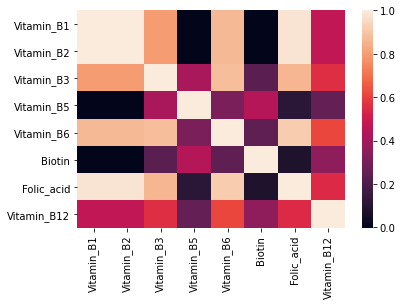

In [16]:
Bs = ['Vitamin_B1', 'Vitamin_B2', 'Vitamin_B3', 'Vitamin_B5', 'Vitamin_B6',  'Biotin', 'Folic_acid', 'Vitamin_B12']
vitamin_B = dfprod.loc[:,Bs]
corrV = vitamin_B.corr()
sns.heatmap(corrV)

From the graph we're concluding that the column we might want to take to represent the Vitamin B group is either Vitamin_B1, Vitamin_B3, Vitamin_B6 or Vitamin_B9 (Folic_acid). 

We chosed them by the number of correlations that are about>=0.8 - by the bright orange colour (we didn't considered Vitamin_B2 because as we can see, the correlation between Vitamin_B1 and Vitamin_B2 is 1).

Now, we'll choose which one of these columns it will be by these criteria:
- the one with the most higher correlations
- the one with the least lower correlations
- the one with the most products in it (the Vitamin with the most products in a better representetive of the data)
- the one with the biggest correlation with column we want to predict - price_per_100g

In [17]:
might_be_rep = ['Vitamin_B1', 'Vitamin_B3', 'Vitamin_B6', 'Folic_acid']
for rep in might_be_rep:
    column_1 = dfprod["price_per_100g"]
    column_2 = dfprod[rep]
    correlation = column_1.corr(column_2)
    print(rep, ": number of correlations that are greater than 0.8: ", (corrV[rep].sort_values(ascending=False)>0.8).sum())
    print(rep, ": number of correlations that are below or equal 0.2: ", (corrV[rep].sort_values(ascending=False)<=0.2).sum())
    print(rep, ": number of products that has value: ", dfprod[rep].astype(bool).sum(axis=0))
    print("correlation between price_per_100g and ",rep,": ", correlation)

Vitamin_B1 : number of correlations that are greater than 0.8:  4
Vitamin_B1 : number of correlations that are below or equal 0.2:  2
Vitamin_B1 : number of products that has value:  247
correlation between price_per_100g and  Vitamin_B1 :  0.017850331414698644
Vitamin_B3 : number of correlations that are greater than 0.8:  3
Vitamin_B3 : number of correlations that are below or equal 0.2:  0
Vitamin_B3 : number of products that has value:  206
correlation between price_per_100g and  Vitamin_B3 :  0.037083577193226025
Vitamin_B6 : number of correlations that are greater than 0.8:  5
Vitamin_B6 : number of correlations that are below or equal 0.2:  0
Vitamin_B6 : number of products that has value:  265
correlation between price_per_100g and  Vitamin_B6 :  0.030040150886635707
Folic_acid : number of correlations that are greater than 0.8:  5
Folic_acid : number of correlations that are below or equal 0.2:  2
Folic_acid : number of products that has value:  271
correlation between price_p

By the two firet criteria we have putted first, it seems that the columns we should take as a representetive for the Vitamin B group is the column of Vitamin_B6 - it has the biggest number of correlations that are greater than 0.8 (which is 5), and it has the smallest number of correlations that are below or equal 0.2 (which is 0). Although Vitamin_B6 dosen't have the biggest correlation between price_per_100g, it has the second biggest one, and the difference between them is not that big.

We thought that we had a problem - the fact that in the Vitamin_B6 there are only 265 products, which is less than 5 precent of our data (it's about three precents - dfprod has 7668 products).

So we tried a different approach - instead of choosing one column to be the representetive of all the group, we tried to merge between the difeerent Vitamin Bs. we gave more significance to Vitamin_B6 and the one's that were designated to be the representetives by this order: first Vitamin_B6, then Vitamin_B3 (who has the best correlation with the price per 100g, and the smallest number of correlations that are below or equal 0.2 as well). Afterwards there was be Vitamin_B9 (Folic_acid) with the next best correlation after the two before and the biggest number of correlations that are greater than 0.8 and then Vitamin_B1. Then there was be Vitamin_B12 ,who has the same number of greater than 0.8 correlations as Vitamin_B5, but fewer correlations that are below or equal 0.2. And last but not least were Biotin and Vitamin_B5 because we can see from the graph that the correlation between Biotin, Vitamin_B5 and the other of the Vitamins is low.

we tried a different combinations of the code that appears in the next window, but it seemed that anything we did made the correlation between the column we tried to create to the price_per_100g to get lower and lower.

In the End we decided to stick with the Vitamin_B6 as the representor of this group, except for Vitamin_B5, Biotin and Vitamin_B12 who had lower correlations with the rest of the Vitamin B's group, so we wanted to look further into them.

In [18]:
#one of the combinations we tried to do:
dfprod = dfprod.reset_index()
dfprod['Vitamin_B_group'] = dfprod['Vitamin_B6']
row=0
for prod in dfprod['Vitamin_B_group']:
    if (prod==0):
        if (dfprod.at[row , 'Vitamin_B3']!=0):
            dfprod.at[row, 'Vitamin_B_group'] =  dfprod.at[row ,'Vitamin_B3']
        elif (dfprod.at[row , 'Folic_acid']!=0):
            dfprod.at[row, 'Vitamin_B_group'] =  dfprod.at[row ,'Folic_acid']
        elif (dfprod.at[row , 'Vitamin_B1']!=0):
            dfprod.at[row, 'Vitamin_B_group'] =  dfprod.at[row ,'Vitamin_B1']
        elif (dfprod.at[row , 'Vitamin_B12']!=0):
            dfprod.at[row, 'Vitamin_B_group'] =  dfprod.at[row ,'Vitamin_B12']
        elif (dfprod.at[row , 'Vitamin_B5']!=0):
            dfprod.at[row, 'Vitamin_B_group'] =  dfprod.at[row ,'Vitamin_B5']
        elif (dfprod.at[row , 'Biotin']!=0):
            dfprod.at[row, 'Vitamin_B_group'] =  dfprod.at[row ,'Biotin']    
    row = row+1        
column_1 = dfprod["price_per_100g"]
column_2 = dfprod['Vitamin_B_group']
correlation = column_1.corr(column_2)
print(correlation)
print(dfprod['Vitamin_B_group'].astype(bool).sum(axis=0))
dfprod = dfprod.set_index(['Product_Name'], drop=True)

-0.006973937296215628
353


In [19]:
dfprod['Partof_vitaminB'] = dfprod['Vitamin_B6']
dfprod = dfprod.drop(['Vitamin_B1', 'Vitamin_B2', 'Vitamin_B3', 'Vitamin_B6', 'Folic_acid'], axis=1)

In [20]:
corr_matrix = dfprod.corr()
corr_matrix['Vitamin_B12'].sort_values(ascending=False).head(10)

Vitamin_B12        1.000000
Partof_vitaminB    0.613192
Biotin             0.359965
Vitamin_E.         0.282495
Vitamin_B5         0.257006
Vitamin_D.         0.256066
copper             0.252972
iodine             0.248395
Vitamin_K.         0.245076
Choline            0.221255
Name: Vitamin_B12, dtype: float64

In [21]:
corr_matrix = dfprod.corr()
corr_matrix['Vitamin_B5'].sort_values(ascending=False).head(10)
#coudln't find the connection between copper and b5, bt found: the need for vitamin B5 is reduced in a copper-deficient(https://www.traceelements.com/Docs/The%20Nutritional%20Relationships%20of%20Copper.pdf)

Vitamin_B5       1.000000
Vitamin_K.       0.486277
copper           0.481449
Vitamin_E.       0.471459
Inositol         0.466317
Choline          0.447913
Biotin           0.446249
iodine           0.408966
Ascorbic_acid    0.371494
Chloride         0.371262
Name: Vitamin_B5, dtype: float64

In [22]:
corr_matrix = dfprod.corr()
corr_matrix['Biotin'].sort_values(ascending=False).head(10)
#the only connection found between biotin and vitamin e is: treation Dietary Supplementation(https://www.drugs.com/drug-interactions/biotin-with-vitamin-e-2926-0-2306-0.html), are both told to help with looks of skin and hair(https://www.everydayhealth.com/pictures/supplements-skin-hair/) 

Biotin         1.000000
Vitamin_E.     0.538266
Vitamin_B5     0.446249
Vitamin_K.     0.402509
copper         0.390171
iodine         0.376650
Vitamin_B12    0.359965
Choline        0.354078
Inositol       0.336089
Nucleotides    0.331447
Name: Biotin, dtype: float64

The highest correlation Vitamin_B12 has with something is with the Partof_vitaminB we made. thus, we can give up on this column as well.

In [23]:
dfprod = dfprod.drop(['Vitamin_B12'], axis = 1)
dfprod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6839 entries, Belgian_lemon-flavored_waffle_for_school to Gluten-free_seed_baguette
Data columns (total 74 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Dietary_fiber                        6839 non-null   float64
 1   energy                               6839 non-null   float64
 2   Proteins                             6839 non-null   float64
 3   Carbohydrates                        6839 non-null   float64
 4   Fats                                 6839 non-null   float64
 5   sodium                               6839 non-null   float64
 6   potassium                            6839 non-null   int64  
 7   Vitamin_C                            6839 non-null   float64
 8   iron                                 6839 non-null   float64
 9   Vitamin_K.                           6839 non-null   float64
 10  Vitamin_E.                           6839

<AxesSubplot:>

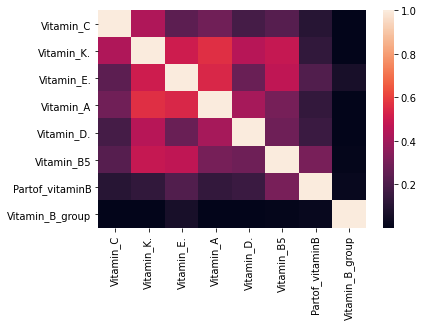

In [24]:
vitamins_lst=['Vitamin_C','Vitamin_K.','Vitamin_E.','Vitamin_A','Vitamin_D.','Vitamin_B5','Partof_vitaminB','Vitamin_B_group']
vitaminS = dfprod.loc[:,vitamins_lst]
corrvl = vitaminS.corr()
sns.heatmap(corrvl)

###### all the things that contains sugars (and Carbohydrate_sugars and Carbohydrate):

<AxesSubplot:>

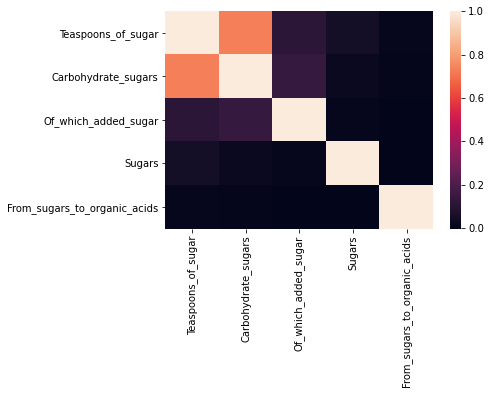

In [25]:
corr_matrix = dfprod.corr()
Sm = ['Teaspoons_of_sugar', 'Carbohydrate_sugars', 'Of_which_added_sugar', 'Sugars', 'From_sugars_to_organic_acids']
Sugars_matix = dfprod.loc[:,Sm]
corrS = Sugars_matix.corr()
sns.heatmap(corrS)

From the graph we can see that the only strong correlation there is between Teaspoons_of_sugar and Carbohydrate_sugars, which is about 0.8.

The correlation between "Teaspoons of sugar" and "Carbohydrate sugars" is high, beacuse as we found at https://www.camoni.co.il/411804/559434, a nutritionist named Marina Broshi explained that Teaspoons of sugar = Carbohydrate sugars/4. 

Now, We'll check the correlation between Teaspoons_of_sugar, Carbohydrate_sugars and price_per_100g (in order to decide on which of the two columns we should give up), But before we'll decide to drop the Carbohydrate sugars (if it'll come to that) column we''ll check as well the correlation between Carbohydrates and Carbohydrate_sugars, as we wanted before.

In [26]:
column_1 = dfprod["Carbohydrate_sugars"]
column_2 = dfprod["Carbohydrates"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrates and Carbohydrate_sugars ", correlation)
column_1 = dfprod["Carbohydrate_sugars"]
column_2 = dfprod["Teaspoons_of_sugar"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrate_sugars and Teaspoons_of_sugar ", correlation)
column_1 = dfprod["Carbohydrate_sugars"]
column_2 = dfprod["price_per_100g"]
correlation = column_1.corr(column_2)
print("correlation between Carbohydrate_sugars and the price per 100g ", correlation)
column_1 = dfprod["Teaspoons_of_sugar"]
column_2 = dfprod["price_per_100g"]
correlation = column_1.corr(column_2)
print("correlation between Teaspoons of sugar and the price per 100g ", correlation)

correlation between Carbohydrates and Carbohydrate_sugars  0.45552970465369486
correlation between Carbohydrate_sugars and Teaspoons_of_sugar  0.7301588432352357
correlation between Carbohydrate_sugars and the price per 100g  0.024584295050148187
correlation between Teaspoons of sugar and the price per 100g  0.035842960679840864


The correlation between Carbohydrate_sugars and Teaspoons_of_sugar is indeed about 0.8 (0.73), and id higher than the correlation between Carbohydrates and Carbohydrate_sugars, which is due to the fact that in the labeling itself, some of the Carbohydrates are Carbohydrate_sugars (as we learn from LJ Amaral, R.D., a registered dietician in https://greatist.com/health/relationship-between-sugar-and-carbs#What-You-Need-to-Know-About-Sugar-and-Carbohydrates-). 

In every product there is a different amount of sugar, and thus the correlation between Carbohydrates and Carbohydrate_sugars is lower than the one between Carbohydrate_sugars and Teaspoons_of_sugar (where there is an exact formula to calculate the connection). 

Due to that, we decided to drop the Carbohydrate sugars column.

In [27]:
dfprod = dfprod.drop(['Carbohydrate_sugars'], axis=1)

In [28]:
corr_matrix = dfprod.corr()
corr_matrix["energy"].sort_values(ascending=False)
print(corr_matrix["energy"].sort_values(ascending=False))
#the correlation between "energy" and "Fats" is high, beacuse as we found at wikipedia, https://he.wikipedia.org/wiki/%D7%A7%D7%9C%D7%95%D7%A8%D7%99%D7%94, energy, which is Calories can be calculated by: 1g of Fats=1g of energy*9
column_1 = dfprod["energy"]
column_2 = dfprod["price_per_100g"]
correlation = column_1.corr(column_2)
print("correlation with energy ", correlation)
column_1 = dfprod["Fats"]
column_2 = dfprod["price_per_100g"]
correlation = column_1.corr(column_2)
print("correlation with Fats ", correlation)
dfprod = dfprod.drop(['energy'], axis=1) #the correlation with Fats is higher. thus, we'll drop the energy column

energy                 1.000000
Fats                   0.755192
Carbohydrates          0.438575
Teaspoons_of_sugar     0.309344
Dietary_fiber          0.219598
                         ...   
Linoleic_fatty_acid   -0.049040
Vitamin_C             -0.052495
chlorine              -0.052922
ARA_fatty_acid        -0.056550
sodium                -0.116058
Name: energy, Length: 73, dtype: float64
correlation with energy  0.03748325030418607
correlation with Fats  0.08301467929792973


<AxesSubplot:>

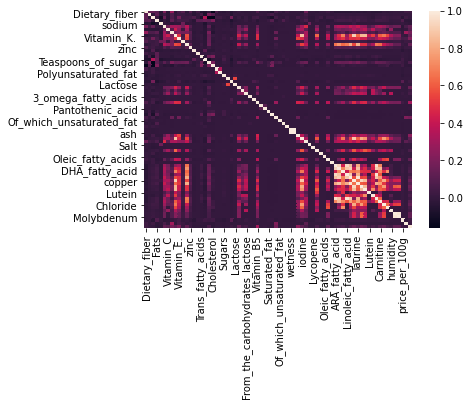

In [29]:
corr_matrix = dfprod.corr()
sns.heatmap(corr_matrix) #in order to see if there's anything else worth checking

Vitamin_A              1.000000
Taurine                0.819951
selenium               0.809348
DHA_fatty_acid         0.744616
chlorine               0.677810
Linoleic_fatty_acid    0.676939
ARA_fatty_acid         0.659442
Carnitine              0.647247
Nucleotides            0.633712
Vitamin_K.             0.565932
copper                 0.546985
Vitamin_E.             0.540874
iodine                 0.534325
Inositol               0.494024
Choline                0.490199
Name: Vitamin_A, dtype: float64


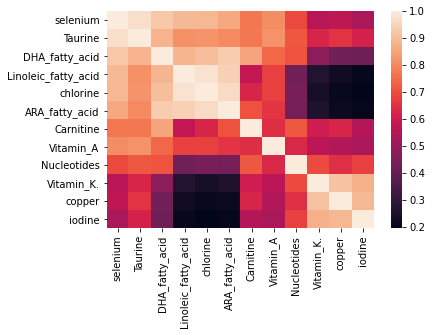

In [30]:
corr_matrix = dfprod.corr()
tw = ['selenium','Taurine','DHA_fatty_acid','Linoleic_fatty_acid','chlorine', 'ARA_fatty_acid','Carnitine','Vitamin_A', 'Nucleotides', 'Vitamin_K.', 'copper', 'iodine']
things_withcorr = dfprod.loc[:,tw]
corrv = things_withcorr.corr()
sns.heatmap(corrv)
print(corr_matrix["Vitamin_A"].sort_values(ascending=False).head(15))
#didn't found the connection between the features, but:
#found a connection between taurine on toxicity of vitamin A in rats: https://www.sciencedirect.com/science/article/abs/pii/S0308814607005420
#found a comparison between chronic taurine and vitamin E plus selenium supplementations: https://pubmed.ncbi.nlm.nih.gov/12688428/
#found a rate studies of destruction of polyunsaturated fatty acids in vitro by chlorine-based disinfectants: https://pubmed.ncbi.nlm.nih.gov/1504266/

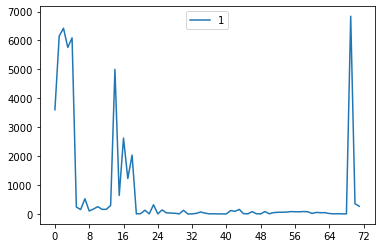

In [31]:
df_num = []
df_name = []
for col in dfprod.columns:
    df_num.append(int(dfprod[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MaxNLocator()) #Dynamically finds major tick positions
plta.show() #in order to check which features can be given up
#it seems that starting from feature number 20, we can give up on those features
#it actually makes sense, because when we did the web scraping, it added to the keys, the names of the columns, 
#a name each time it was not already there. therefore, we would expect the common keys to be at the beginning of the columns

In [32]:
dfprod2 = dfprod.iloc[:,:20] #we'll try creating a new train-set, with only the first 31 features, and put it aside for now
dfprod2['price_per_100g'] = dfprod['price_per_100g']
dfprod2

,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,potassium,Vitamin_C,iron,Vitamin_K.,Vitamin_E.,...,Vitamin_A,zinc,Of_which_added_sugar,Of_which_saturated_fat,Trans_fatty_acids,Teaspoons_of_sugar,calcium,Cholesterol,Monounsaturated_fat,price_per_100g
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.80,9.20,6.30,17.5,0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,3.30,0.00,0.00,0.0,0.0,0,4.95
Pasta_Perfecto_Casserole,1.60,0.00,0.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0,1.38
Whole_champignon_mushrooms,2.20,2.10,0.90,0.00,240.0,0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0,1.65
Light_bread_from_whole_spelled,2.45,3.07,8.46,0.39,86.9,0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.12,0.00,0.00,0.0,0.0,0,3.90
Baby_bite_flavored_vegetables,0.00,0.00,2.00,0.00,6.0,0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.10,0.00,0.00,0.0,0.0,0,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,6.30,76.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.00,11.25,0.0,0.0,0,9.86
Slim_Delis_Multi-Grain_Milk,1.60,0.80,7.40,2.60,36.4,0,0.0,0.0,0.0,0.52,...,34.5,0.0,0.0,1.40,0.00,8.75,0.0,0.0,0,9.08
Chocolate_with_popsicles,0.00,8.10,58.00,27.00,117.0,0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,16.50,0.00,14.25,0.0,29.0,0,6.11


In [33]:
dfprod = dfprod.reset_index()
dfprod

,Product_Name,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,potassium,Vitamin_C,iron,Vitamin_K.,...,chlorine,Carnitine,Chloride,AA_fatty_acid,humidity,chromium,Molybdenum,price_per_100g,Vitamin_B_group,Partof_vitaminB
0,Belgian_lemon-flavored_waffle_for_school,0.00,0.80,9.20,6.30,17.5,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,4.95,0.0,0.0
1,Pasta_Perfecto_Casserole,1.60,0.00,0.00,0.00,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1.38,0.0,0.0
2,Whole_champignon_mushrooms,2.20,2.10,0.90,0.00,240.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1.65,0.0,0.0
3,Light_bread_from_whole_spelled,2.45,3.07,8.46,0.39,86.9,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,3.90,0.0,0.0
4,Baby_bite_flavored_vegetables,0.00,0.00,2.00,0.00,6.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,25.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6834,Epic_Cola_Candy,0.00,6.30,76.00,0.00,0.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,9.86,0.0,0.0
6835,Slim_Delis_Multi-Grain_Milk,1.60,0.80,7.40,2.60,36.4,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,9.08,0.1,0.1
6836,Chocolate_with_popsicles,0.00,8.10,58.00,27.00,117.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,6.11,0.0,0.0
6837,Smoked_mozzarella_slices,0.00,21.50,0.00,22.00,500.0,0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,9.25,0.0,0.0


In [34]:
#back with the original dataframe
arr = np.array([])
col_droped = np.array([])
for col in dfprod.columns:
    if dfprod[col].astype(bool).sum(axis=0)<50: #all the features that less than precent of the products have
        arr = np.append(arr, dfprod[col].to_numpy().nonzero())
        col_droped = np.append(col_droped, col)
print(arr)
arr = set(arr) #all number of rows without duplicates
for i in arr:
    dfprod = dfprod.drop(i)
dfprod = dfprod.loc[:, (dfprod != 0).any(axis=0)] #deletes all columns with all values set to zero
dfprod = dfprod.set_index(['Product_Name'])
dfprod

[2323. 4379. 4727.  339. 2323. 2518. 2595. 2749. 3392. 4727. 5085. 5246.
 5631. 6400. 1551. 6439. 1283. 1551. 2079.   28.  220.  232.  261.  265.
  376.  421.  505.  527.  528.  557. 1406. 1479. 1670. 1999. 2083. 2510.
 2606. 2678. 3120. 3258. 3374. 3383. 3697. 3698. 3806. 3966. 4371. 4449.
 4541. 4635. 4717. 5586. 5720. 5723. 5905. 6157. 6782. 6832.   28.   65.
  220.  232.  261.  265.  376.  528. 1006. 1406. 1446. 1860. 1999. 2697.
 3120. 3258. 3343. 3374. 3526. 3530. 3806. 3863. 4014. 4311. 4790. 4884.
 5411. 5582. 5586. 5905. 6157.  175.  336.  952. 2154. 2198. 2339. 2432.
 2514. 2536. 2541. 2902. 3760. 3961. 4212. 4223. 4590. 4962. 5121. 5938.
 6007. 6613. 6776. 6801.  586. 3500. 4984. 5605. 6026. 5605.  179.  569.
  587.  943. 1044. 1061. 1471. 2484. 2620. 3859. 3996. 4111. 4164. 4815.
 4969. 5088. 5485. 5645. 6260. 6378. 6737.   93.  287.  335.  987. 1771.
 2013. 2353. 2377. 2535. 2611. 3285. 3527. 3603. 3715. 3758. 4191. 4207.
 4407. 4440. 4776. 5527. 5585. 5633. 5703. 5867. 60

,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,potassium,Vitamin_C,iron,Vitamin_K.,Vitamin_E.,...,manganese,Ascorbic_acid,selenium,copper,Choline,Inositol,Alpha_linolenic_acid,price_per_100g,Vitamin_B_group,Partof_vitaminB
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.80,9.20,6.30,17.5,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,4.95,0.0,0.0
Pasta_Perfecto_Casserole,1.60,0.00,0.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,1.38,0.0,0.0
Whole_champignon_mushrooms,2.20,2.10,0.90,0.00,240.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,1.65,0.0,0.0
Light_bread_from_whole_spelled,2.45,3.07,8.46,0.39,86.9,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,3.90,0.0,0.0
Baby_bite_flavored_vegetables,0.00,0.00,2.00,0.00,6.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,25.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,6.30,76.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,9.86,0.0,0.0
Slim_Delis_Multi-Grain_Milk,1.60,0.80,7.40,2.60,36.4,0,0.0,0.0,0.0,0.52,...,0,0,0,0,0,0,0,9.08,0.1,0.1
Chocolate_with_popsicles,0.00,8.10,58.00,27.00,117.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,6.11,0.0,0.0


In [35]:
def variance_threshold_selector(data, threshold=(0.8 * (1 - .8))):
    selector = VarianceThreshold(threshold) #VarianceThreshold removes all low-variance features.
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [36]:
col_fell_thresh = np.array([])
dfprodvar = variance_threshold_selector(dfprod, threshold=(0.8 * (1 - .8)))
for col in dfprod.columns:
    if col not in dfprodvar.columns:
        col_fell_thresh = np.append(col_fell_thresh, col)
print(col_fell_thresh)
dfprod = dfprodvar
dfprod

['Vitamin_B5' 'selenium' 'Choline' 'Inositol' 'Partof_vitaminB']


,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,potassium,Vitamin_C,iron,Vitamin_K.,Vitamin_E.,...,Saturated_fatty_acids,Biotin,iodine,phosphorus,manganese,Ascorbic_acid,copper,Alpha_linolenic_acid,price_per_100g,Vitamin_B_group
Product_Name,,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.80,9.20,6.30,17.5,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,4.95,0.0
Pasta_Perfecto_Casserole,1.60,0.00,0.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,1.38,0.0
Whole_champignon_mushrooms,2.20,2.10,0.90,0.00,240.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,1.65,0.0
Light_bread_from_whole_spelled,2.45,3.07,8.46,0.39,86.9,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,3.90,0.0
Baby_bite_flavored_vegetables,0.00,0.00,2.00,0.00,6.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,25.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,6.30,76.00,0.00,0.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,9.86,0.0
Slim_Delis_Multi-Grain_Milk,1.60,0.80,7.40,2.60,36.4,0,0.0,0.0,0.0,0.52,...,0,5,0,0,0,0,0,0,9.08,0.1
Chocolate_with_popsicles,0.00,8.10,58.00,27.00,117.0,0,0.0,0.0,0.0,0.00,...,0,0,0,0,0,0,0,0,6.11,0.0


In [37]:
for i in tw:
    if i in dfprod.columns:
        print(i)

Vitamin_A
Vitamin_K.
copper
iodine


In [38]:
col_fell_thresh2 = np.array([])
dfprodvar2 = variance_threshold_selector(dfprod2, threshold=(0.8 * (1 - .8)))
for col in dfprod2.columns:
    if col not in dfprodvar2.columns:
        col_fell_thresh2 = np.append(col_fell_thresh2, col)
print(col_fell_thresh2)
dfprod2 = dfprodvar2
dfprod2 #noticed that non of the features fell in this data set!

['Monounsaturated_fat']


,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,potassium,Vitamin_C,iron,Vitamin_K.,Vitamin_E.,Magnesium,Vitamin_A,zinc,Of_which_added_sugar,Of_which_saturated_fat,Trans_fatty_acids,Teaspoons_of_sugar,calcium,Cholesterol,price_per_100g
Product_Name,,,,,,,,,,,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.80,9.20,6.30,17.5,0,0.0,0.0,0.0,0.00,0,0.0,0.0,0.0,3.30,0.00,0.00,0.0,0.0,4.95
Pasta_Perfecto_Casserole,1.60,0.00,0.00,0.00,0.0,0,0.0,0.0,0.0,0.00,0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1.38
Whole_champignon_mushrooms,2.20,2.10,0.90,0.00,240.0,0,0.0,0.0,0.0,0.00,0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,1.65
Light_bread_from_whole_spelled,2.45,3.07,8.46,0.39,86.9,0,0.0,0.0,0.0,0.00,0,0.0,0.0,0.0,0.12,0.00,0.00,0.0,0.0,3.90
Baby_bite_flavored_vegetables,0.00,0.00,2.00,0.00,6.0,0,0.0,0.0,0.0,0.00,0,0.0,0.0,0.0,0.10,0.00,0.00,0.0,0.0,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,6.30,76.00,0.00,0.0,0,0.0,0.0,0.0,0.00,0,0.0,0.0,0.0,0.00,0.00,11.25,0.0,0.0,9.86
Slim_Delis_Multi-Grain_Milk,1.60,0.80,7.40,2.60,36.4,0,0.0,0.0,0.0,0.52,0,34.5,0.0,0.0,1.40,0.00,8.75,0.0,0.0,9.08
Chocolate_with_popsicles,0.00,8.10,58.00,27.00,117.0,0,0.0,0.0,0.0,0.00,0,0.0,0.0,0.0,16.50,0.00,14.25,0.0,29.0,6.11


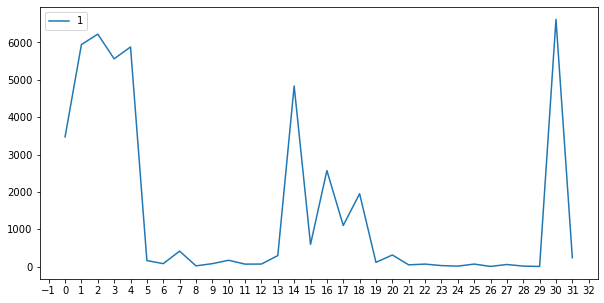

In [39]:
df_num = []
df_name = []
for col in dfprod.columns:
    df_num.append(int(dfprod[col].astype(bool).sum(axis=0)))
    df_name.append(col)
df2 = pd.DataFrame([df_name, df_num]).transpose()
ax = df2.plot(x_compat=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator()) #Dynamically finds major tick positions
plta.gcf().set_size_inches(10, 5)
plta.show() #in order to check which features can be given up
#it seems that we shoul pick the next features:
#no. 1, 3-7(not including 7), 18, 20, 21, 22, 35

In [40]:
ss= [0 ,1, 2, 3, 4 ,15, 17, 18, 19, 30]
dfprod3 = dfprod.iloc[:, ss]
dfprod3 #the idea behind taking the features with more than 1000 non-zero values is that as long as the feature is appearing more
#it can help us to be more accurate for a bigger complex of producrs

,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,Trans_fatty_acids,calcium,Cholesterol,Sugars,price_per_100g
Product_Name,,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.80,9.20,6.30,17.5,0.00,0.0,0.0,0,4.95
Pasta_Perfecto_Casserole,1.60,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0,1.38
Whole_champignon_mushrooms,2.20,2.10,0.90,0.00,240.0,0.00,0.0,0.0,0,1.65
Light_bread_from_whole_spelled,2.45,3.07,8.46,0.39,86.9,0.00,0.0,0.0,0,3.90
Baby_bite_flavored_vegetables,0.00,0.00,2.00,0.00,6.0,0.00,0.0,0.0,0,25.00
...,...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,6.30,76.00,0.00,0.0,0.00,0.0,0.0,0,9.86
Slim_Delis_Multi-Grain_Milk,1.60,0.80,7.40,2.60,36.4,0.00,0.0,0.0,0,9.08
Chocolate_with_popsicles,0.00,8.10,58.00,27.00,117.0,0.00,0.0,29.0,0,6.11


In [41]:
corr_matrix = dfprod3.corr()
corr_matrix['price_per_100g'].sort_values(ascending=False)

price_per_100g       1.000000
Fats                 0.082647
Cholesterol          0.036211
calcium              0.020821
sodium               0.014803
Trans_fatty_acids    0.009257
Proteins             0.006634
Dietary_fiber       -0.001125
Sugars              -0.015229
Carbohydrates       -0.034386
Name: price_per_100g, dtype: float64

# end of data cleaning

In [42]:
'''t2_col = []
t2_index = train_set2.index.values.tolist()
t1_col = []
t1_index = train_set1.index.values.tolist()
for col in train_set2.columns:
    t2_col.append(col)
for col in train_set1.columns:
    t1_col.append(col)
scaler = MinMaxScaler()
train_set1 = scaler.fit_transform(train_set1)
train_set2 = scaler.fit_transform(train_set2)
train_set2 = pd.DataFrame(train_set2, index=t2_index, columns=t2_col)
train_set1 = pd.DataFrame(train_set1, index=t1_index, columns=t1_col)'''

't2_col = []\nt2_index = train_set2.index.values.tolist()\nt1_col = []\nt1_index = train_set1.index.values.tolist()\nfor col in train_set2.columns:\n    t2_col.append(col)\nfor col in train_set1.columns:\n    t1_col.append(col)\nscaler = MinMaxScaler()\ntrain_set1 = scaler.fit_transform(train_set1)\ntrain_set2 = scaler.fit_transform(train_set2)\ntrain_set2 = pd.DataFrame(train_set2, index=t2_index, columns=t2_col)\ntrain_set1 = pd.DataFrame(train_set1, index=t1_index, columns=t1_col)'

In [43]:
products1 = dfprod.drop("price_per_100g", axis=1)
products_prices1 = dfprod["price_per_100g"].copy()
products2 = dfprod2.drop("price_per_100g", axis=1)
products_prices2 = dfprod2["price_per_100g"].copy()
products3 = dfprod3.drop("price_per_100g", axis=1)
products_prices3 = dfprod3["price_per_100g"].copy()

In [44]:
products3

,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,Trans_fatty_acids,calcium,Cholesterol,Sugars
Product_Name,,,,,,,,,
Belgian_lemon-flavored_waffle_for_school,0.00,0.80,9.20,6.30,17.5,0.00,0.0,0.0,0
Pasta_Perfecto_Casserole,1.60,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0
Whole_champignon_mushrooms,2.20,2.10,0.90,0.00,240.0,0.00,0.0,0.0,0
Light_bread_from_whole_spelled,2.45,3.07,8.46,0.39,86.9,0.00,0.0,0.0,0
Baby_bite_flavored_vegetables,0.00,0.00,2.00,0.00,6.0,0.00,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,0.00,6.30,76.00,0.00,0.0,0.00,0.0,0.0,0
Slim_Delis_Multi-Grain_Milk,1.60,0.80,7.40,2.60,36.4,0.00,0.0,0.0,0
Chocolate_with_popsicles,0.00,8.10,58.00,27.00,117.0,0.00,0.0,29.0,0


In [45]:
p1_col = []
p1_index = products1.index.values.tolist()
for col in products1.columns:
    p1_col.append(col)
scaled_features1 = StandardScaler().fit_transform(products1.values)
products_preapered1 = pd.DataFrame(scaled_features1, index=p1_index, columns=p1_col)
p3_col = []
p3_index = products3.index.values.tolist()
for col in products3.columns:
    p3_col.append(col)
scaled_features3 = StandardScaler().fit_transform(products3.values)
products_preapered3 = pd.DataFrame(scaled_features3, index=p3_index, columns=p3_col)
p2_col = []
p2_index = products2.index.values.tolist()
for col in products2.columns:
    p2_col.append(col)
scaled_features2 = StandardScaler().fit_transform(products2.values)
products_preapered2 = pd.DataFrame(scaled_features2, index=p2_index, columns=p2_col)
products_preapered3

,Dietary_fiber,Proteins,Carbohydrates,Fats,sodium,Trans_fatty_acids,calcium,Cholesterol,Sugars
Belgian_lemon-flavored_waffle_for_school,-0.562179,-0.421629,-0.730133,-0.425259,-0.194283,-0.142933,-0.297348,-0.322754,-0.063093
Pasta_Perfecto_Casserole,-0.209937,-0.468075,-1.038775,-0.848651,-0.200485,-0.142933,-0.297348,-0.322754,-0.063093
Whole_champignon_mushrooms,-0.077847,-0.346153,-1.008581,-0.848651,-0.115425,-0.142933,-0.297348,-0.322754,-0.063093
Light_bread_from_whole_spelled,-0.022809,-0.289836,-0.754958,-0.822441,-0.169686,-0.142933,-0.297348,-0.322754,-0.063093
Baby_bite_flavored_vegetables,-0.562179,-0.468075,-0.971679,-0.848651,-0.198359,-0.142933,-0.297348,-0.322754,-0.063093
...,...,...,...,...,...,...,...,...,...
Epic_Cola_Candy,-0.562179,-0.102308,1.510874,-0.848651,-0.200485,-0.142933,-0.297348,-0.322754,-0.063093
Slim_Delis_Multi-Grain_Milk,-0.209937,-0.421629,-0.790519,-0.673918,-0.187584,-0.142933,-0.297348,-0.322754,-0.063093
Chocolate_with_popsicles,-0.562179,0.002196,0.907010,0.965886,-0.159018,-0.142933,-0.297348,0.518781,-0.063093
Smoked_mozzarella_slices,-0.562179,0.780177,-1.038775,0.629860,-0.023277,0.881280,3.498527,1.592463,-0.063093


In [46]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(products_preapered1, products_prices1)
some_data = products_preapered1.iloc[69:925]
some_labels = products_prices1.iloc[69:925]
print("predicitions:", lin_reg.predict(some_data))
print("lables:", list(some_labels))
from sklearn.metrics import mean_squared_error
predictions1 = lin_reg.predict(products_preapered1)
lin_mse1 = mean_squared_error(products_prices1, predictions1)
lin_rmse1 = np.sqrt(lin_mse1)
lin_rmse1

predicitions: [ 7.91643909  5.7669694   6.13972982  7.1727994  13.97124103  6.8629607
  7.87777491  7.07935652  9.51445276  5.41496372  7.1644744   6.33490191
  7.47430283  5.29689286  5.28393549  7.95396429  4.6067383   5.89749812
  6.99663083  6.22827691  6.22143052  5.95328568 14.93619095  6.33679996
  9.03532216  4.31165846  7.47508825  5.95267501  7.38419214  8.47138648
  6.87466765  5.67114205  5.24898309  8.35272703  6.37354628  7.43040793
  4.83962498  8.875918    6.85649643  6.61075099  3.56968184  6.24148547
  7.76992299  7.06155333 15.05429173  9.18777209  9.40736841  6.74359986
  6.91484165  9.29892524  7.90226243  6.62682686 14.67497932  6.62893262
  4.98688999 15.58558387  6.89707886  7.04365376  4.14222399  6.93331888
  7.43025558  8.49644113  4.90384772  7.10208946  5.31086348  7.21791929
  7.52185009  8.28822864  6.74631913  7.08072696  5.29222103  7.43369933
  7.22877653  6.84611553  6.85220162  6.76340169  6.38573642  6.99786922
 10.01783515  7.11334475  7.01051159  

10.018998319421506

In [47]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(products_preapered2, products_prices2)
some_data = products_preapered2.iloc[69:925]
some_labels = products_prices2.iloc[69:925]
print("predicitions:", lin_reg.predict(some_data))
print("lables:", list(some_labels))
from sklearn.metrics import mean_squared_error
predictions2 = lin_reg.predict(products_preapered2)
lin_mse2 = mean_squared_error(products_prices2, predictions2)
lin_rmse2 = np.sqrt(lin_mse2)
lin_rmse2

predicitions: [ 7.94219059  8.29212553  7.21073093  7.84991105  6.24569596  6.88690439
  7.14040176  5.7960339   6.9945917   7.79726037  7.10857795  9.26870238
  6.13003652  7.17894491  6.63916787  7.4644262   6.05980139  5.19524631
  7.89140767  5.59746164  6.33147737  7.02539516  6.66711911  6.51738669
 11.1641213   6.26781365  5.64924734  6.70524501  8.85272471  5.4279707
  7.66081605  6.19848452  7.94816441  8.59190531  6.89157071  5.71869344
  4.82179948  8.19509218  6.59949178  7.52811766  5.47388668  8.77259227
  6.80955714  6.69358339  3.82696282  6.63040992  7.80500958  7.03157778
  5.64126336  8.97319317  9.29582471  7.17969669  7.33325813  9.01894658
  8.09516585  6.50814834  5.5009939   7.36782443  5.86939094  5.49697323
  7.41882127  7.08764921  4.11580165  6.88301988  7.33632751  8.49090395
  5.78087799  7.14002976  6.84215192  5.09887805  7.33517636  7.49996665
  7.36139877  6.92693729  7.04486043  6.09465975  7.80849494  7.25464574
  6.88013001  6.86185948  6.81408847  

9.98036513006474

In [48]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(products_preapered3, products_prices3)
some_data = products_preapered3.iloc[69:925]
some_labels = products_prices3.iloc[69:925]
print("predicitions:", lin_reg.predict(some_data))
print("lables:", list(some_labels))
from sklearn.metrics import mean_squared_error
predictions3 = lin_reg.predict(products_preapered3)
lin_mse3 = mean_squared_error(products_prices3, predictions3)
lin_rmse3 = np.sqrt(lin_mse3)
lin_rmse3

predicitions: [ 7.93083455  6.40426001  7.63355755  6.97767755  6.20235053  7.31338028
  7.63382757  7.04641832  8.31682524  6.45219507  7.07093015  6.8875716
  7.46153072  6.29029661  6.85587816  7.97432658  6.09837132  6.47911732
  6.95155472  6.85993252  6.55247575  6.1786967   6.12332164  6.8501198
  7.47919165  5.97286612  7.89403659  6.61124255  8.53952625  8.38751087
  6.79573049  5.78964296  6.23695149  6.07002926  6.61961609  7.65696157
  6.02847352  8.92726199  6.76119136  6.57240917  5.98626034  6.70122861
  8.26397013  6.57604289  6.1374799   8.75494959  9.58618092  7.48020367
  7.57090479  7.9725064   7.63187887  6.60765099  6.04374502  8.02049432
  6.29017722  6.04139187  7.82042491  6.98013093  6.73933648  6.61826285
  7.15613525  7.56654153  6.13243305  6.90422461  6.61058092  7.3909711
  6.82498614  7.06526763  6.95490545  6.67214727  6.25309801  8.18597427
  7.0794772   6.82193992  6.72327369  6.71708752  6.44078692  6.95081638
  9.39418897  7.05366354  8.11538598  9.

10.150556784288158

In [49]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(products_preapered1,products_prices1)
predictionst1 = tree_reg.predict(products_preapered1)
tree_mse1 = mean_squared_error(products_prices1, predictionst1)
tree_rmse1 = np.sqrt(tree_mse1)
print(tree_rmse1)

2.4184526497727092


In [50]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(products_preapered2,products_prices2)
predictionst2 = tree_reg.predict(products_preapered2)
tree_mse2 = mean_squared_error(products_prices2, predictionst2)
tree_rmse2 = np.sqrt(tree_mse2)
print(tree_rmse2)

2.4002970857299397


In [51]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(products_preapered3,products_prices3)
predictionst3 = tree_reg.predict(products_preapered3)
tree_mse3 = mean_squared_error(products_prices3, predictionst3)
tree_rmse3 = np.sqrt(tree_mse3)
print(tree_rmse3)

2.492733594954664


In [52]:
'''from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(products_preapered3,products_prices3)
predictionst3 = tree_reg.predict(products_preapered3)
tree_mse = mean_squared_error(products_prices3, predictionst3)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)'''

'from sklearn.tree import DecisionTreeRegressor\ntree_reg = DecisionTreeRegressor()\ntree_reg.fit(products_preapered3,products_prices3)\npredictionst3 = tree_reg.predict(products_preapered3)\ntree_mse = mean_squared_error(products_prices3, predictionst3)\ntree_rmse = np.sqrt(tree_mse)\nprint(tree_rmse)'